## Albumentations - Augmentation for Object Detection Tasks

Example dataset: https://www.kaggle.com/andrewmvd/road-sign-detection
- PASCAL VOC FORMAT, XML PARSING REQUIRED

### Download Dataset

In [1]:
! kaggle datasets download -d andrewmvd/road-sign-detection

road-sign-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
! unzip road-sign-detection.zip

Archive:  road-sign-detection.zip
replace annotations/road0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import os
import albumentations as A
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm.notebook import tqdm

### Pre-define Functions

- XML Parser
- Image reader (and convert)
- Draw bounding boxes

In [2]:
def process_xml(xml_paths_lst):
    """
    Returns - List
    List : [[image_path, [[cordinates..., label]]]]
    """
    enc_class = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
    result = []
    for img in tqdm(xml_paths_lst):
        result_per_img = []
        a = ET.parse(img)
        a_root = a.getroot()
        filename = a_root.find('filename').text
        filename = os.path.join('./images/', filename)
        result_per_img.append(filename)
        objects = a_root.findall('object')
        bboxes = []
        for obj in objects:
            obj_name = obj.find('name').text
            obj_x_min = float(obj.find('./bndbox/xmin').text)
            obj_y_min = float(obj.find('./bndbox/ymin').text)
            obj_x_max = float(obj.find('./bndbox/xmax').text)
            obj_y_max = float(obj.find('./bndbox/ymax').text)
            bbox_label_info = [obj_x_min, obj_y_min, obj_x_max, obj_y_max, enc_class[obj_name]]
            bboxes.append(bbox_label_info)
        result_per_img.append(bboxes)
        result.append(result_per_img)
    return result

def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def draw_boxes(image, bboxes):
    """
    Returns a drawn image
    """
    dec_class = {0: 'speedlimit', 1: 'stop', 2: 'crosswalk', 3: 'trafficlight'}
    # Draw every boxes in a single image
    for box in bboxes:
        start, end = (int(box[0]), int(box[3])), (int(box[2]), int(box[1]))
        image = cv2.rectangle(image, start, end, color=(0,255,255), thickness=3)
        image = cv2.putText(image, dec_class[box[-1]], (int(box[0]), int(box[1])), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,255), 2)
    return image

### Parse XML

In [3]:
annotations_paths_lst = glob('./annotations/*.xml')

result = process_xml(annotations_paths_lst)

  0%|          | 0/877 [00:00<?, ?it/s]

### 1. Show Untransformed Images with Bounding Boxes

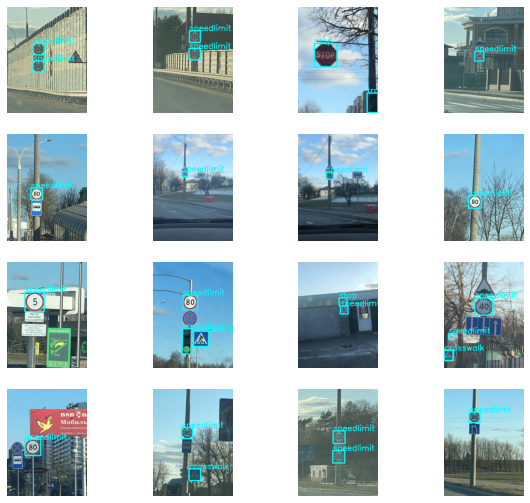

In [4]:
fig = plt.figure(figsize=(10, 9))
rows = 4
cols = 4

for idx, img_ in enumerate(result[:rows * cols]):
    img_path, bboxes = img_
    image = read_image(img_path)
    image = draw_boxes(image, bboxes)
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.imshow(image)
    ax.axis('off')
plt.show()

### Setting Albumentations

In [5]:
transform = A.Compose([
    A.HorizontalFlip(p=0.8),
    # A.Cutout(num_holes=1, max_h_size=30),
    # A.Rotate(limit=75),
    A.RandomRotate90(),
    A.RandomBrightnessContrast(p=0.8)
    ], 
    bbox_params=A.BboxParams(format='pascal_voc'))

### 2. Show Transformed Images with Transformed Bounding Boxes

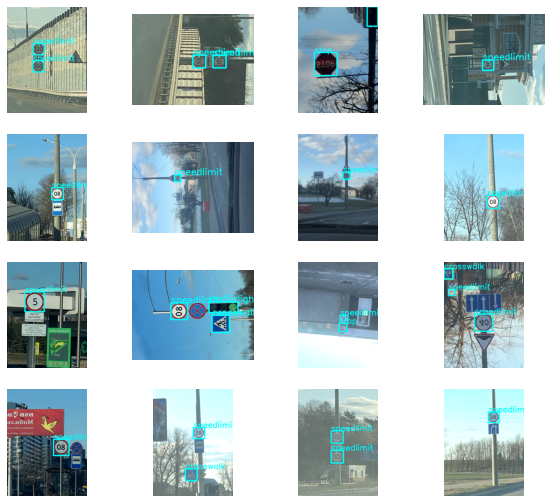

In [6]:
fig = plt.figure(figsize=(10, 9))
rows = 4
cols = 4

for idx, img_ in enumerate(result[:rows * cols]):
    img_path, bboxes = img_
    image = read_image(img_path)
    transformed = transform(image=image, bboxes=bboxes)
    image = transformed['image']
    bboxes = transformed['bboxes']
    image = draw_boxes(image, bboxes)
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.imshow(image)
    ax.axis('off')
plt.show()

### 3. PyTorch Usage

In [7]:
from copy import deepcopy

class BoundingBoxDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        img_path = self.x_data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bbox_label = self.y_data[idx]
        if self.transform:
            transformed = self.transform(image=image, bboxes=bbox_label)
            image = transformed['image']
            bbox_label = transformed['bboxes']
#         image = np.array(image).astype('float') / 255.
#         bbox_label = np.array(bbox_label)
        sample = {'image': image, 'bboxes': bbox_label}
        return sample
    
X = [i[0] for i in result]
y = [i[1] for i in result]

# X_train, X_test, y_train, y_test = train_test_split(X, y)

dataset = BoundingBoxDataset(X, y, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

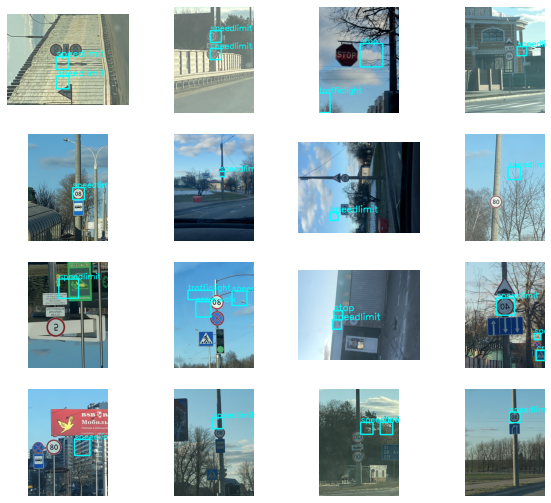

In [8]:
fig = plt.figure(figsize=(10, 9))
rows = 4
cols = 4

for idx in range(rows*cols):
    image = dataset[idx]['image']
    bboxes = dataset[idx]['bboxes']
    image = draw_boxes(image, bboxes)
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.imshow(image)
    ax.axis('off')
plt.show()